# Tutorial for resVAE ensemble

Here, we will show a brief tutorial or demo for using resVAE ensemble.

We will cover only resVAE ensemble here, so please refer to the documentations of scanpy or anndata as needed:
* scanpy: https://scanpy.readthedocs.io/en/stable/
* anndata: https://anndata.readthedocs.io/en/stable/

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
os.environ['TF_KERAS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd

from resVAE_ensemble.resvae import resVAE
import resVAE_ensemble.utils as cutils
import resVAE_ensemble.tools as ctools
from resVAE_ensemble.config import config

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style()
sns.set_theme('paper')

from sklearn.preprocessing import normalize

import re
import dill

import anndata as ad
import scanpy as sc
sc.set_figure_params(scanpy=True, fontsize=14, dpi=120)
sc.settings.n_jobs = 10
sc.settings.set_figure_params(dpi=90, facecolor='white', fontsize=12)

## Loading data
The toy data used is obtained from scanpy, please check the following link for more information:
https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.krumsiek11.html

In [2]:
anndata = sc.datasets.krumsiek11()
anndata

/fususers/foowei/mambaforge/envs/tf29/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights'

## Preparing inputs for resVAE

Since the resVAE architecture expects inputs values in the range between 0 and 1, we will normalize the values.

is dense!


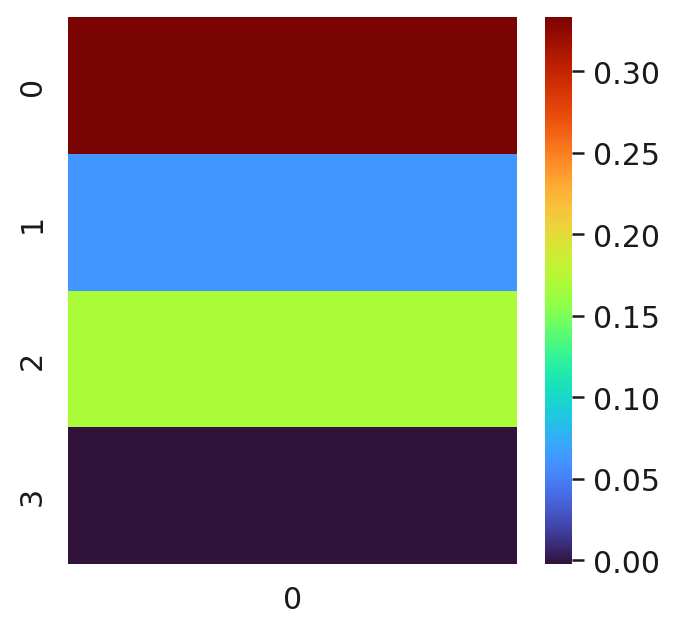

In [3]:
norm_counts, normalizer = cutils.check_and_normalize_counts(anndata.X)

Additionally, we will also prepare the one-hot encoded label matrix.

The metadata for the data can be accessed using the `.obs` property of an AnnData object (if present).

Of course, you can use your own table or dataframe as well.

In the following steps, we will encode the `cell_type` column in the metadata and smoothen the labels.

In [4]:
genes = anndata.var_names.to_numpy()
resvae_clusters = anndata.obs.copy()
resvae_clusters.dtypes

cell_type    category
dtype: object

In [5]:
encodings, labels = cutils.add_encoders(resvae_clusters, include=['cell_type'])
encodings = cutils.smooth_labels(encodings).astype(np.float32)
encodings, labels

(640, 5) (5,)


(array([[1.562500e-04, 1.562500e-04, 1.562500e-04, 1.562500e-04,
         9.001562e-01],
        [1.562500e-04, 1.562500e-04, 1.562500e-04, 1.562500e-04,
         9.001562e-01],
        [1.562500e-04, 1.562500e-04, 1.562500e-04, 1.562500e-04,
         9.001562e-01],
        ...,
        [1.562500e-04, 1.562500e-04, 1.562500e-04, 9.001562e-01,
         1.562500e-04],
        [1.562500e-04, 1.562500e-04, 1.562500e-04, 9.001562e-01,
         1.562500e-04],
        [1.562500e-04, 1.562500e-04, 1.562500e-04, 9.001562e-01,
         1.562500e-04]], dtype=float32),
 array(['Ery', 'Mk', 'Mo', 'Neu', 'progenitor'], dtype=object))

## Setting up the model config

Now we just need to specify the hyperparameters we want to use for the models.

Here's an example:

In [6]:
config['INPUT_SHAPE'] = (norm_counts.shape[1], encodings.shape[1])
config['DECODER_REGULARIZER'] = 'none'
config['DECODER_REGULARIZER_INITIAL'] = 1e-6
config['LATENT_SCALE'] = 1
config['OPTIMIZER'] = 'LARAdam'
config['LR'] = 1e-3
config['ACTIVATION'] = 'Mish'
config['INITIALIZER'] = 'glorot_uniform'
config['ENCODER_SHAPE'] = [512,256]
config['DECODER_SHAPE'] = [256,512]
config['CB_ES_USE'] = True
config['CB_SAVE_BEST'] = False
config['CB_LR_MIN_DELTA'] = 0.0001
config['CB_ES_MIN_DELTA'] = 0.00001
config['CB_LR_PATIENCE'] = 30
config['CB_ES_PATIENCE'] = config['CB_LR_PATIENCE'] * 3
config['VALIDATION_SPLIT'] = 0.2
config['DROPOUT'] = 0
config['BATCH_SIZE'] = 32
config['BASE_LOSS'] = 'mse'

config['ALPHA'] = 1
config['BETA'] = 1

assert config['INPUT_SHAPE'][0] == anndata.shape[1] == len(genes)

## Training resVAE ensemble

Finally, we're ready to train the ensemble!

For the ease of demonstration, here we will simply train 5 independent models sequentially now.

Here we trained multiple models using identical inputs and model config. However, you could also spice things up by varying the hyperparameters for each model.


In [7]:
%%time

cutils.train_ensemble(counts=norm_counts,
                    encodings=encodings,
                    labels=labels,
                    genes=genes,
                    config=config,
                    n_runs=5,
                    model_name="Mish-a1-b1",
                    model_dir="tut_demo/models/Mish-a1-b1")

/fususers/foowei/mambaforge/envs/tf29/lib/python3.10/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 75: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 105: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 135: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 135: early stopping
Saving model...
resVAE weights saved!

@==============================@ Finished run # 0 Mish-a1-b1

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 97: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 127: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 127: early stopping
Saving model...
resVAE weights saved!

@==============================@ Finished run # 1 Mish-a1-b1

Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 211: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 241: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 253: early stopping
Saving m

We will proceed to load the weights from the trained models.

In [8]:
df = cutils.load_multirun(mname="Mish-a1-b1",
                        weights_key='weights_clusters',
                        in_dir="tut_demo/models",
                        out_dir="tut_demo/models/outputs",
                        genes=genes)

Dill file not found: tut_demo/models/outputs/Mish-a1-b1/None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


## Visualizations of the trained models

In [9]:
from sklearn.preprocessing import minmax_scale

df_norm = df.copy()
df_norm.iloc[:,0:-2] = minmax_scale(df_norm.iloc[:,0:-2].T,
                                    feature_range=(-1,1)
                                    ).T

/tmp/ipykernel_3813268/3859123732.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_norm.iloc[:,0:-2] = minmax_scale(df_norm.iloc[:,0:-2].T,


Here, we briefly inspected the consistencies of the different trained models.

One way to visualize this is to simply plot a parallel coordinates plot that shows the different features for each label.

A consistent ensemble should have similar curves across the different models, as shown by consistent or overlapping lines.

<AxesSubplot: >

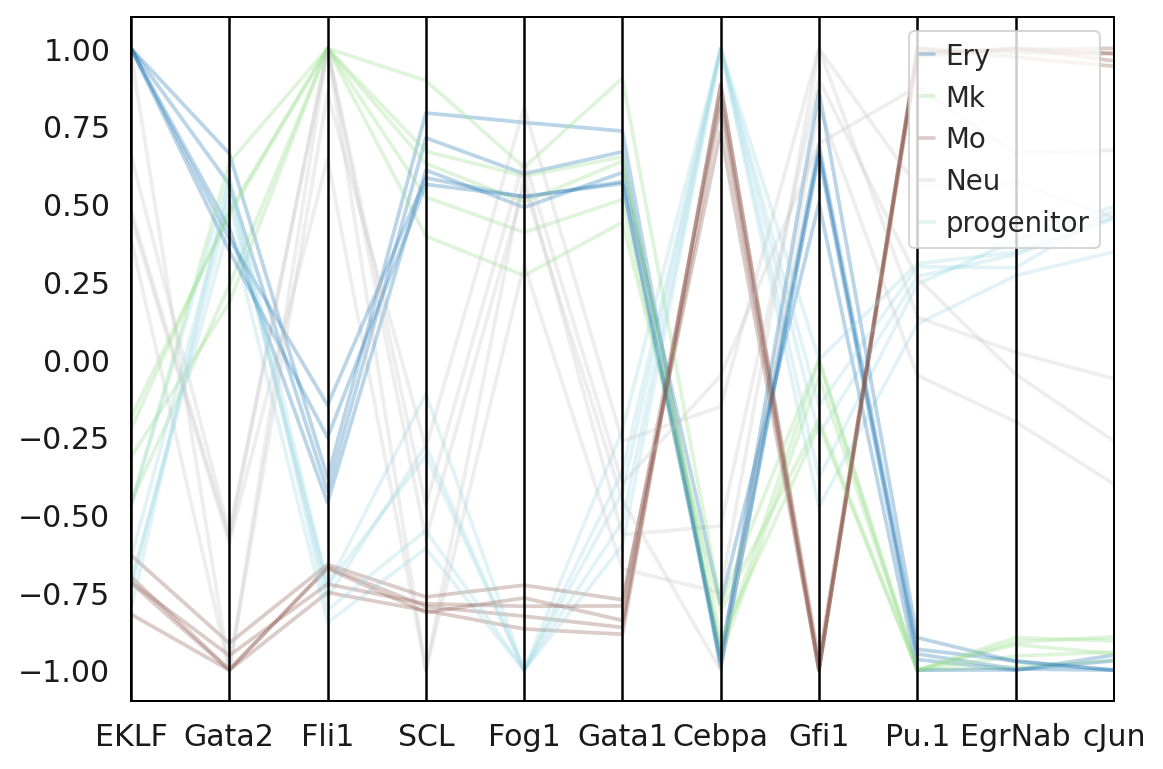

In [10]:
plt.figure(figsize=(7,5))
pd.plotting.parallel_coordinates(
    df_norm.drop(columns=['_run']).loc[:,
    ['EKLF', 'Gata2', 'Fli1', 'SCL', 'Fog1', 'Gata1', 'Cebpa', 'Gfi1', 'Pu.1', 'EgrNab', 'cJun', '_label']
], '_label',
    alpha=0.3,
    colormap='tab20',
)

Another way is to visualize this as an Andrews curves plot.

<AxesSubplot: >

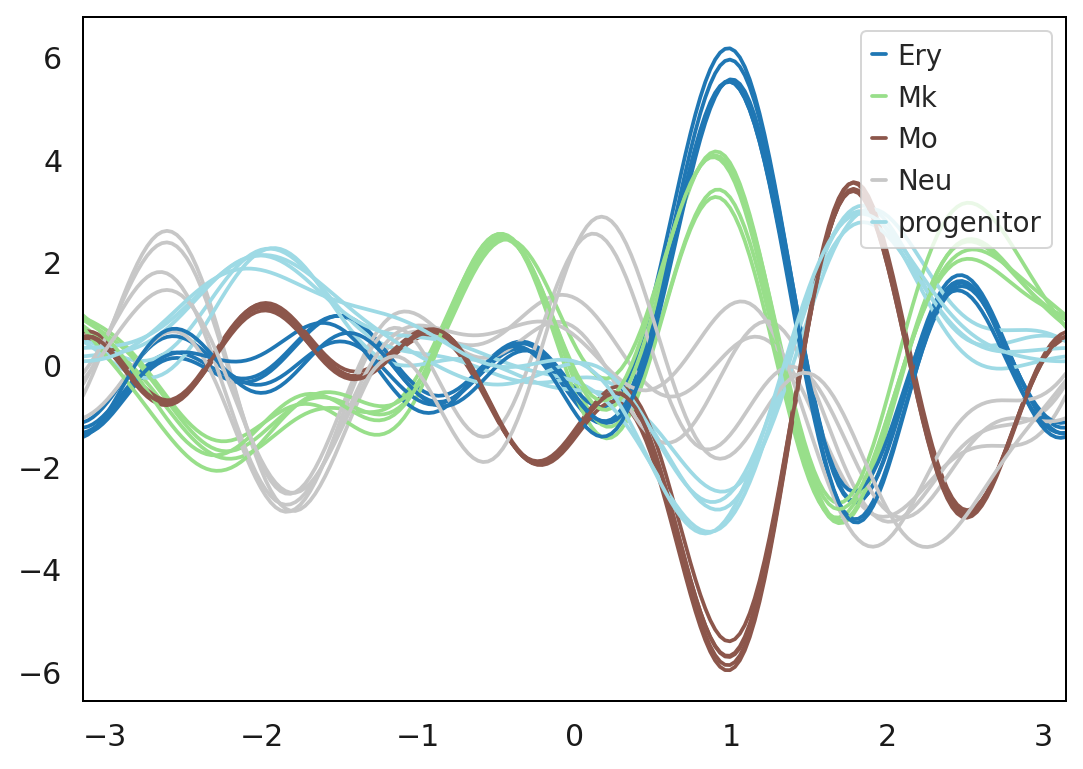

In [11]:
plt.figure(figsize=(7,5))
pd.plotting.andrews_curves(df_norm.drop(columns=['_run']), class_column='_label', colormap='tab20')

Alternatively, we can also visualize the models using heatmaps.

In [28]:
def plot_resvae_models(df, run, **kwargs):
    d = df.query(f'`_run` == "{run}"')
    d = d.set_index('_label')
    sns.heatmap(
        data = d.loc[:, ['EKLF','Gata2','Fli1','SCL','Fog1','Gata1','Cebpa','Gfi1','Pu.1','EgrNab','cJun']].T,
        cmap=kwargs.pop('cmap', 'coolwarm'), linewidths=1,
        #annot=True,
        linecolor='black', square=True, cbar_kws={"shrink": .2}, annot=False,
        **kwargs
        )
    plt.title(f'Model: #{run}')
    return d
    
def plot_resvae_labels(df, label, **kwargs):
    d = df.query(f'`_label` == "{label}"')
    d = d.set_index('_run')
    sns.heatmap(
        data = d.loc[:, ['EKLF','Gata2','Fli1','SCL','Fog1','Gata1','Cebpa','Gfi1','Pu.1','EgrNab','cJun']].T,
        cmap=kwargs.pop('cmap', 'coolwarm'), linewidths=1,
        #annot=True,
        linecolor='black', square=True,
        cbar_kws={"shrink": .2}, annot=False,
        **kwargs
        )
    plt.title(f'Cluster: {label}')
    return d

For example, we can visualize the performance of a single model for the different labels and features.

,Gata2,Gata1,Fog1,EKLF,Fli1,SCL,Cebpa,Pu.1,cJun,EgrNab,Gfi1,_run
_label,,,,,,,,,,,,
Ery,0.562764,0.667298,0.596570,1.000000,-0.425110,0.711947,-0.993711,-0.965901,-0.951688,-1.000000,0.657860,0
Mk,0.238192,0.513686,0.408406,-0.459213,1.000000,0.521604,-0.934218,-1.000000,-0.946831,-0.917729,-0.005970,0
Mo,-1.000000,-0.862471,-0.826450,-0.719323,-0.668545,-0.795307,0.881322,0.987094,1.000000,0.995798,-0.971258,0
Neu,-0.559133,-0.564291,0.593858,0.656205,1.000000,-1.000000,-0.536257,0.261766,-0.263323,-0.047989,0.900180,0
progenitor,0.538510,-0.361787,-1.000000,-0.641405,-0.765644,-0.278065,1.000000,0.241789,0.490987,0.382059,-0.379454,0


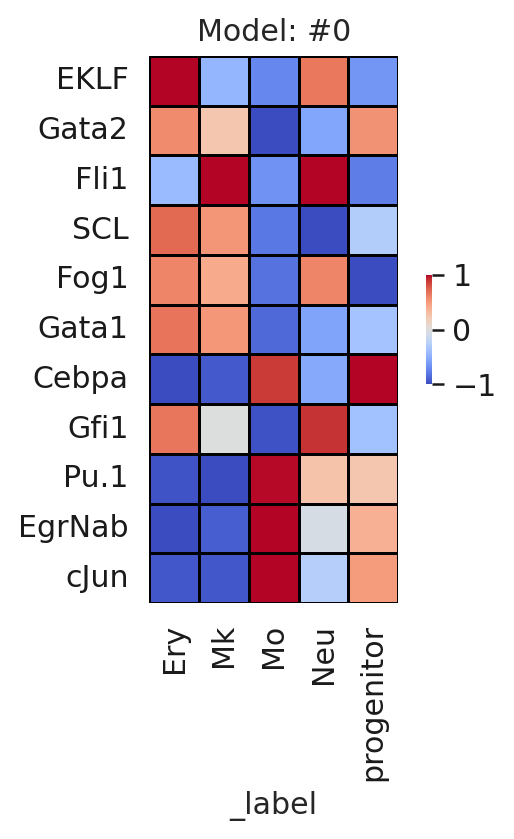

In [29]:
plot_resvae_models(df_norm, run=0)

In addition, we can also visualize the performance of a specific label across all trained models.

,Gata2,Gata1,Fog1,EKLF,Fli1,SCL,Cebpa,Pu.1,cJun,EgrNab,Gfi1,_label
_run,,,,,,,,,,,,
0,0.562764,0.667298,0.596570,1.0,-0.425110,0.711947,-0.993711,-0.965901,-0.951688,-1.000000,0.657860,Ery
1,0.661773,0.734001,0.761619,1.0,-0.382074,0.792108,-0.983917,-0.947726,-1.000000,-0.996062,0.669531,Ery
2,0.388356,0.571299,0.520974,1.0,-0.147931,0.583557,-0.950720,-0.932573,-1.000000,-0.969941,0.690961,Ery
3,0.420496,0.600400,0.488594,1.0,-0.461679,0.608242,-0.786796,-1.000000,-0.969640,-0.999035,0.501809,Ery
4,0.348900,0.565292,0.523616,1.0,-0.251609,0.562487,-0.969936,-0.895374,-1.000000,-0.972458,0.863435,Ery


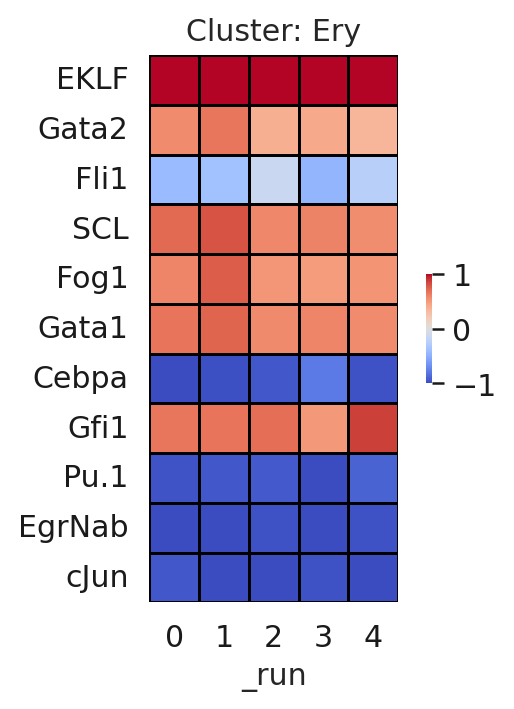

In [30]:
plot_resvae_labels(df_norm, label='Ery')

## Rank aggregation of ensemble

Here we will perform the rank aggregation of the ensemble.

In [15]:
cluster_cutoffs = cutils.aggregate_cutoffs(df,
                                           classes=labels,
                                           nrun=0,
                                           )
cluster_cutoffs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.94it/s]


{'Ery': 2, 'Mk': 2, 'Mo': 1, 'Neu': 4, 'progenitor': 2}

In [16]:
clusters_ranking = cutils.aggregate_rankings(df,
                                             classes=labels,
                                             nrun=0
                                            )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 338.74it/s]


In [31]:
rra_clusters = ctools.pyRRA_mp(clusters_ranking,
                               workers=len(clusters_ranking.keys()),
                               cutoffs=None)
resvae_rra = cutils.rra_clusters_export(rra_clusters)

  0%|                                                                                                         …

Here we can inspect the consensus from resVAE ensemble.

In [34]:
resvae_rra.head()

,Name,Score,BH_adj,Name_cleaned,cluster
0,Fli1,0.000031,0.000342,Fli1,Mk
1,SCL,0.007544,0.027662,SCL,Mk
2,Gata1,0.007544,0.027662,Gata1,Mk
3,Fog1,0.097019,0.213442,Fog1,Mk
4,Gata2,0.097019,0.213442,Gata2,Mk


In [18]:
resvae_rra_norm = resvae_rra.loc[:,["Name", "BH_adj", "cluster"]].pivot(index='cluster', columns='Name', values='BH_adj')
resvae_rra_norm = np.abs(np.log10(resvae_rra_norm))

for i in range(len(resvae_rra_norm.index)):
    resvae_rra_norm.iloc[i] = (resvae_rra_norm.iloc[i] - np.min(resvae_rra_norm.iloc[i])) / (np.max(resvae_rra_norm.iloc[i]) - np.min(resvae_rra_norm.iloc[i]))

resvae_rra_norm

Name,Cebpa,EKLF,EgrNab,Fli1,Fog1,Gata1,Gata2,Gfi1,Pu.1,SCL,cJun
cluster,,,,,,,,,,,
Ery,0.000000,1.000000,0.000000,0.024868,0.193481,0.269261,0.102116,0.193481,0.000000,0.269261,0.000000
Mk,0.000000,0.024868,0.000000,1.000000,0.193481,0.449465,0.193481,0.102116,0.000000,0.449465,0.000000
Mo,0.539581,0.009820,1.000000,0.140108,0.000000,0.000000,0.000000,0.000000,0.794369,0.000000,0.794369
Neu,0.000000,0.125136,0.125136,1.000000,0.125136,0.000000,0.000000,0.454466,0.228847,0.000000,0.043951
progenitor,1.000000,0.000000,0.193481,0.000000,0.000000,0.000000,0.449465,0.000000,0.193481,0.000000,0.449465


<AxesSubplot: xlabel='cluster', ylabel='Name'>

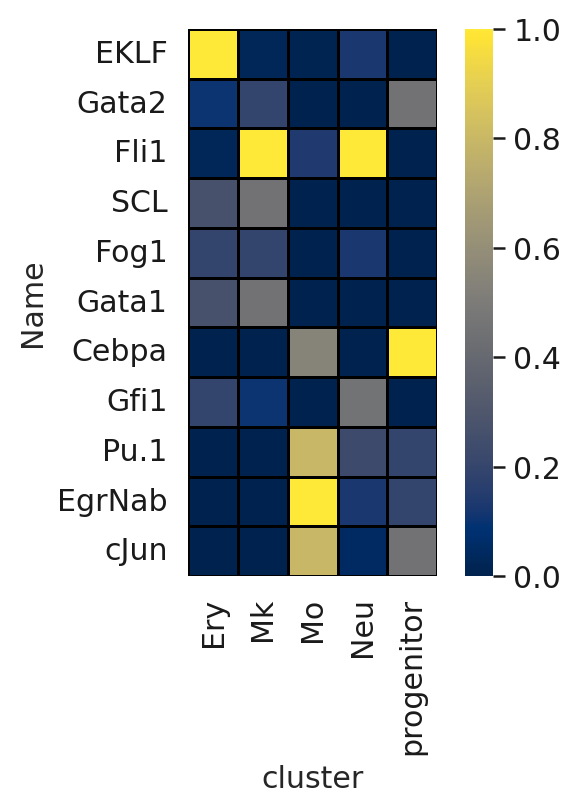

In [19]:
sns.heatmap(data = resvae_rra_norm.loc[:, ['EKLF','Gata2','Fli1','SCL','Fog1','Gata1','Cebpa','Gfi1','Pu.1','EgrNab','cJun']].T,
            cmap="cividis", linewidths=1, linecolor='black', square=True, vmin=0, vmax=1, )

In [20]:
rank_cons = cutils.rra_ranking_consistency(clusters_ranking, k=1)

for i in [2,3]:
    _df = cutils.rra_ranking_consistency(clusters_ranking, k=i)
    rank_cons = pd.concat([rank_cons, _df])

rank_cons

,cluster,top_features,counts,k_sum,sum,overlap,k
Ery,Ery,"(EKLF,)","(5,)",5,5,1.0,1
Mk,Mk,"(Fli1,)","(5,)",5,5,1.0,1
Mo,Mo,"(EgrNab,)","(2,)",2,5,0.4,1
Neu,Neu,"(Fli1,)","(3,)",3,5,0.6,1
progenitor,progenitor,"(Cebpa,)","(5,)",5,5,1.0,1
Ery,Ery,"(EKLF, SCL)","(5, 3)",8,10,0.8,2
Mk,Mk,"(Fli1, Gata1)","(5, 3)",8,10,0.8,2
Mo,Mo,"(EgrNab, Pu.1)","(5, 3)",8,10,0.8,2
Neu,Neu,"(Fli1, Gfi1)","(5, 4)",9,10,0.9,2
progenitor,progenitor,"(Cebpa, Gata2)","(5, 4)",9,10,0.9,2
